# Environment Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")

In [2]:
#load dataset
df = pd.read_csv("AFE.csv")

In [3]:
df.head()

,Report_ID,Date,Aircraft_Make,Aircraft_Model,Flight_Phase,System,Component,Severity,Location,Narrative,Root_Cause_Keywords,Model_Age
0,4059770,2021-01-18,Airbus,A350,Cruise,Hydraulic,Pump,Low,NJ,"Pump failed to respond, irregular cycling obse...","pump, hydraulic",14
1,4021362,2016-07-03,Embraer,E190,Climb,A/C (Environmental),Compressor,Moderate,GA,Compressor cycling irregularly; passenger disc...,"compressor, a/c",21
2,4127324,2010-09-01,Airbus,A320,Climb,Electrical,Bus Tie,Low,AZ,Bus Tie fault reported; unexpected shutdown le...,"bus_tie, electrical",25
3,4140509,2024-10-25,Boeing,777-300,Taxi,A/C (Environmental),Ventilation Fan,Moderate,MD,Reports of checklist execution due to Ventilat...,"ventilation_fan, a/c",30
4,4144297,2024-04-19,ATR,ATR72,Landing,Avionics,Flight Computer,Low,CO,Flight Computer produced erroneous reading...,"flight_computer, avionics",29


In [5]:
df.shape

(150300, 12)

In [6]:
df.columns

Index(['Report_ID', 'Date', 'Aircraft_Make', 'Aircraft_Model', 'Flight_Phase',
       'System', 'Component', 'Severity', 'Location', 'Narrative',
       'Root_Cause_Keywords', 'Model_Age'],
      dtype='object')

## Data Quality Check

In [11]:
# missing values
df.isnull().sum().sort_values(ascending = False)

Narrative              1603
Component               750
Severity                447
Report_ID                 0
Date                      0
Aircraft_Make             0
Aircraft_Model            0
Flight_Phase              0
System                    0
Location                  0
Root_Cause_Keywords       0
Model_Age                 0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150300 entries, 0 to 150299
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Report_ID            150300 non-null  int64 
 1   Date                 150300 non-null  object
 2   Aircraft_Make        150300 non-null  object
 3   Aircraft_Model       150300 non-null  object
 4   Flight_Phase         150300 non-null  object
 5   System               150300 non-null  object
 6   Component            149550 non-null  object
 7   Severity             149853 non-null  object
 8   Location             150300 non-null  object
 9   Narrative            148697 non-null  object
 10  Root_Cause_Keywords  150300 non-null  object
 11  Model_Age            150300 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 13.8+ MB


In [13]:
#hence date is object, cobnvert to dateTime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

## Fault Landscape

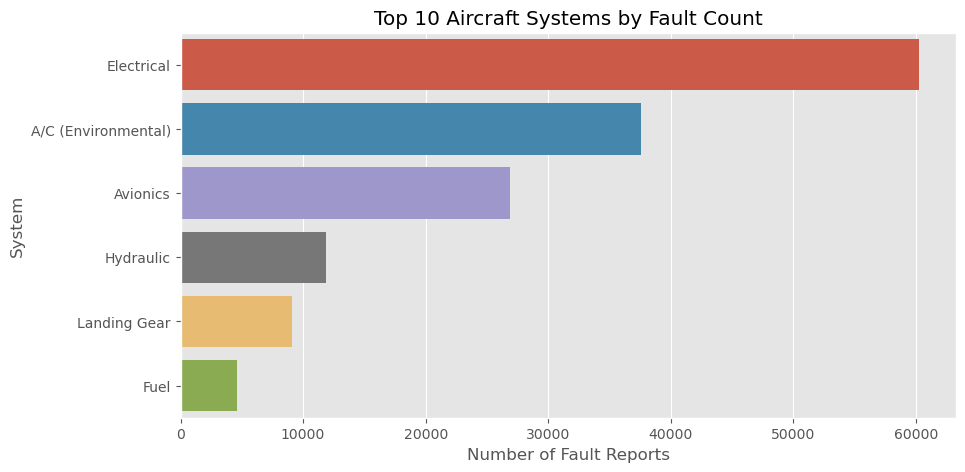

In [14]:
#Fault Count by System
system_counts = df['System'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=system_counts.values, y=system_counts.index)
plt.title("Top 10 Aircraft Systems by Fault Count")
plt.xlabel("Number of Fault Reports")
plt.ylabel("System")
plt.show()

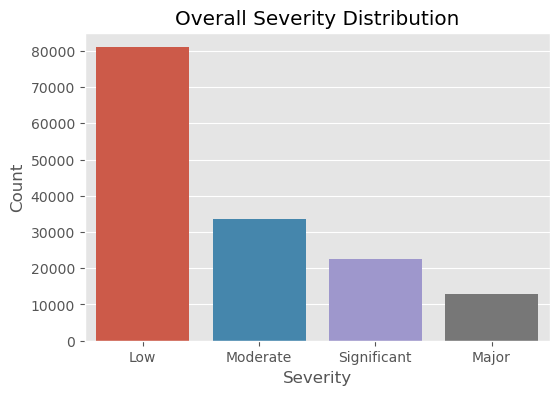

In [15]:
# severity distribution
severity_counts = df['Severity'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.title("Overall Severity Distribution")
plt.ylabel("Count")
plt.show()

## System × Severity

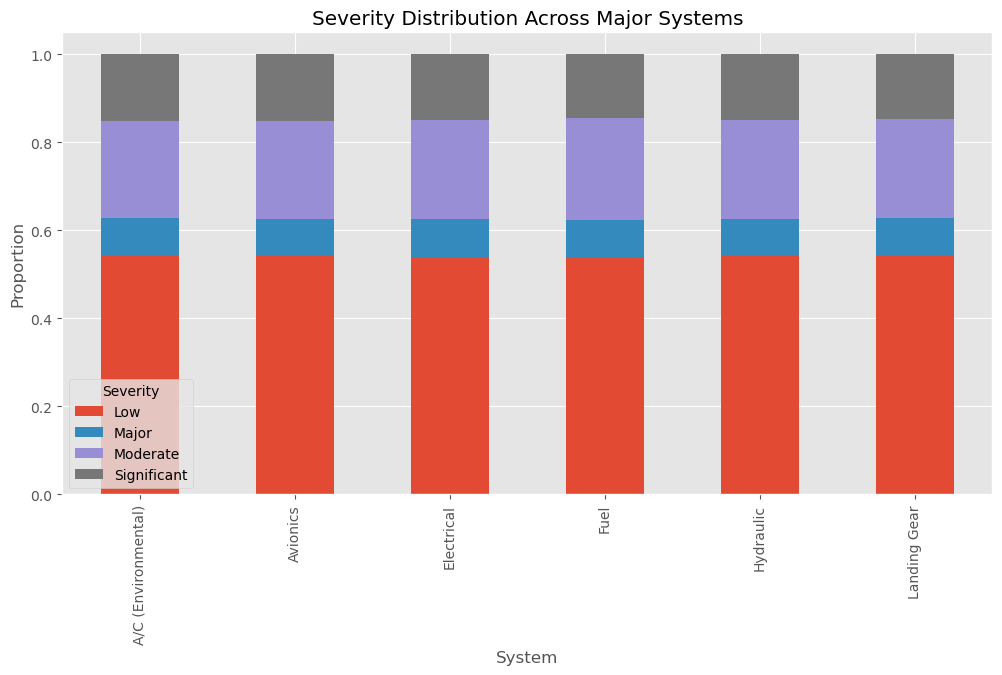

In [16]:
# severity by system
system_severity = pd.crosstab(df['System'], df['Severity'], normalize='index')

system_severity.loc[
    system_severity.sum(axis=1).sort_values(ascending=False).head(8).index
].plot(kind='bar', stacked=True, figsize=(12,6))

plt.title("Severity Distribution Across Major Systems")
plt.ylabel("Proportion")
plt.show()

## Flight Phase Sensitivity

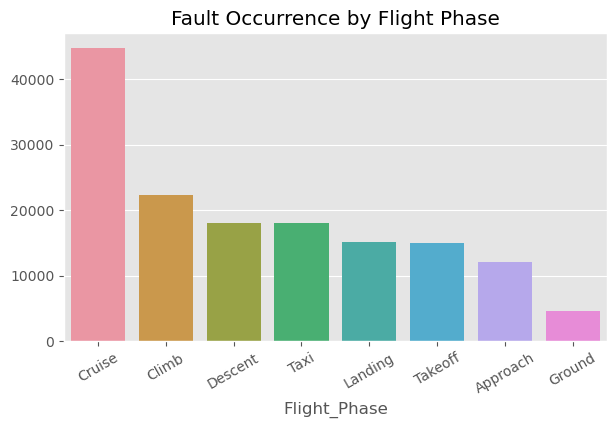

In [17]:
#faults by flight phase
phase_counts = df['Flight_Phase'].value_counts()

plt.figure(figsize=(7,4))
sns.barplot(x=phase_counts.index, y=phase_counts.values)
plt.title("Fault Occurrence by Flight Phase")
plt.xticks(rotation=30)
plt.show()

In [18]:
pd.crosstab(df['System'], df['Flight_Phase']).head()

Flight_Phase,Approach,Climb,Cruise,Descent,Ground,Landing,Takeoff,Taxi
System,,,,,,,,
A/C (Environmental),3043,5553,11162,4567,1164,3796,3775,4531
Avionics,2257,4037,7917,3200,822,2724,2694,3225
Electrical,4757,8999,18144,7340,1755,6150,5846,7218
Fuel,388,668,1397,518,135,458,490,579
Hydraulic,951,1800,3469,1402,389,1176,1283,1415


## Aircraft Age Effect

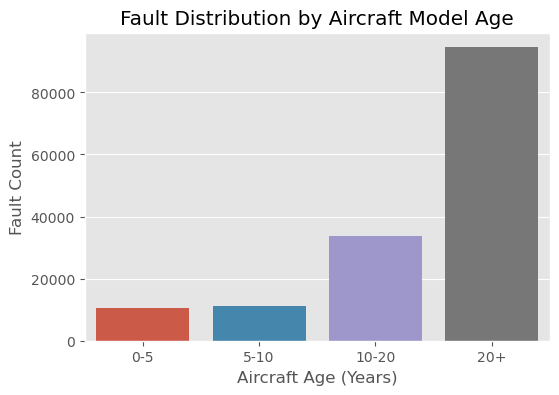

In [20]:
# model age

df['Age_Bucket'] = pd.cut(
    df['Model_Age'],
    bins=[0,5,10,20,50],
    labels=['0-5','5-10','10-20','20+']
)

age_faults = df['Age_Bucket'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=age_faults.index, y=age_faults.values)
plt.title("Fault Distribution by Aircraft Model Age")
plt.xlabel("Aircraft Age (Years)")
plt.ylabel("Fault Count")
plt.show()

#### *Older aircraft models exhibit increased fault density, reinforcing age as a key predictive feature*

## Narrative Readiness Check

In [21]:
# narrative length
df['Narrative_Length'] = df['Narrative'].astype(str).apply(len)
df['Narrative_Length'].describe()

count    150300.000000
mean         83.717239
std          15.742756
min           3.000000
25%          75.000000
50%          82.000000
75%          92.000000
max         172.000000
Name: Narrative_Length, dtype: float64

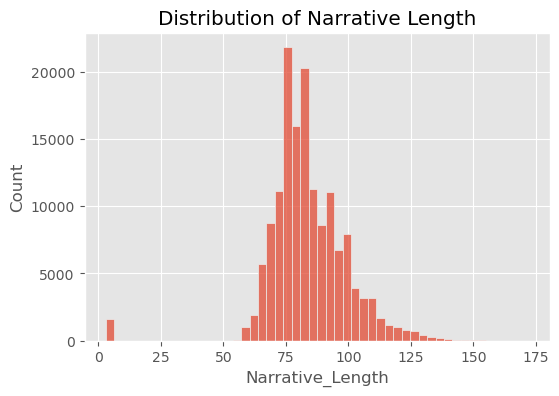

In [22]:
plt.figure(figsize=(6,4))
sns.histplot(df['Narrative_Length'], bins=50)
plt.title("Distribution of Narrative Length")
plt.show()

## EDA: system-level fault patterns and severity analysis